Extracting the trips

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('cleaned_data.csv',index_col=0)
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

trips = []
trip = []
in_trip = False
for idx, row in df.iterrows():  #trip starts when engine_rpm increases from zero (engine starts) and ends when engine_rpm again reaches zero (engine turns off)
    if row['engine_rpm'] > 0:
        if not in_trip:         #checking if the car was already in trip or not
            in_trip = True      #starting a new trip as car was not in a trip
            trip = []
        trip.append(row)
    elif row['engine_rpm'] == 0:
        if in_trip:             #since there are many zero value, so checking if the car was already in a trip if yes then end the trip
            in_trip = False
            if trip:
                trips.append(pd.DataFrame(trip)) #adding the trip to the trips list


Preparing the trips data

In [4]:
trips_dict = {'trip_start':[],'trip_end':[], 'duration (mins)':[], 'avg_speed':[], 'max_speed':[], 'dist':[], 'MAF':[], 'FAR':[]}
for i in trips:
    trips_dict['trip_start'].append(i.iloc[0]['time_stamp'])
    trips_dict['trip_end'].append(i.iloc[-1]['time_stamp'])
    
    duration = (i.iloc[-1]['time_stamp'] - i.iloc[0]['time_stamp']).total_seconds()
    trips_dict['duration (mins)'].append(duration/60)
        
    trips_dict['avg_speed'].append(i.loc[i['vehicle_speed']!=0, 'vehicle_speed'].mean())
    trips_dict['max_speed'].append(i['vehicle_speed'].max())

    i['time_diff'] = i['time_stamp'].diff().dt.total_seconds()
    i['time_till_speed_continued'] = i['time_diff'].shift(-1)
    i['final_speed'] = i['vehicle_speed'].shift(-1)
    i['acceleration'] = ((i['final_speed']- i['vehicle_speed'])*1000/3600) / i['time_till_speed_continued']
    i['distance'] = round(((i['vehicle_speed']*1000/3600)*i['time_till_speed_continued']) + (0.5*i['acceleration']*(i['time_till_speed_continued']**2)),2)
    

    temp = i.iloc[-1]['vehicle_speed']*1000/3600
    i.at[i.index[-1],'acceleration'] = (0-temp)/2
    i.at[i.index[-1],'distance'] = round(temp*2 + 0.5*((0-temp)/2)*4)

    trips_dict['dist'].append((i['distance'].sum())/1000)


    maf = (i['mass_air_flow_rate'] *i['time_till_speed_continued']).sum() / i['time_till_speed_continued'].sum()
    trips_dict['MAF'].append(maf/1000)
    trips_dict['FAR'].append(i['o_s1_b1_fuel_air_equivalence_ratio'].mean())

trips_df = pd.DataFrame(trips_dict)
trips_df = trips_df.dropna(subset=['avg_speed']).reset_index(drop=True)

Finding the Time Difference between Trips

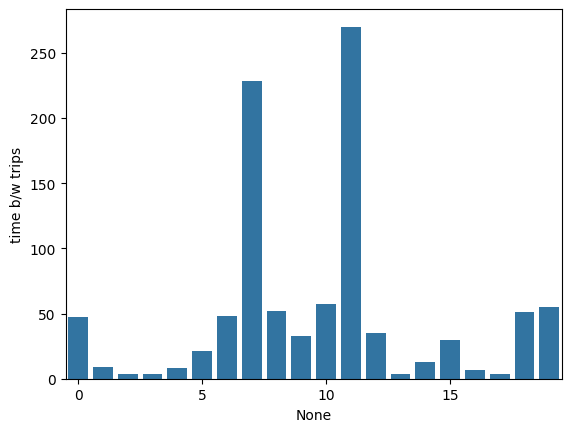

Number of Trips: 97
Average Speed: 20.02
Maximum Speed: 109.0


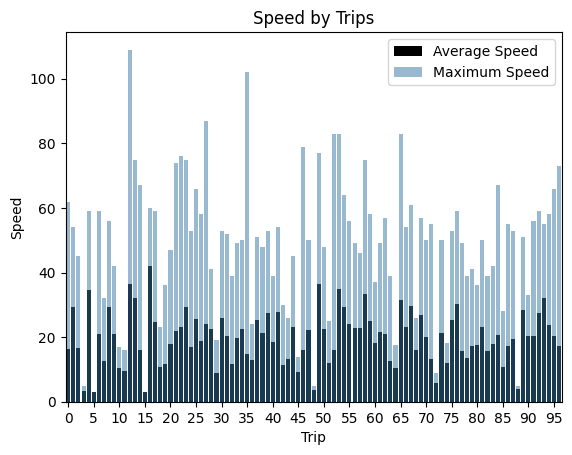

In [5]:
trips_df['time b/w trips'] = (trips_df['trip_start'].shift(-1) - trips_df['trip_end']).dt.total_seconds()

# trips_df['fuel_mass_flow_rate'] = trips_df['MAF'] / trips_df['FAR']

# trips_df['fuel consumption (kg)'] = trips_df['fuel_mass_flow_rate'] * (trips_df['duration (mins)']*60) #converting to seconds

# trips_df['fuel_consumption (liters)'] = trips_df['fuel consumption (kg)'] / 0.75 #density of fuel = 0.75 kg/

# speed_labels = ['0-10','11-20','21-30','31-40','41-50','50+']
# speed_bins = [0,10,20,30,40,50,np.inf]
# trips_df['Speed Brackets'] = pd.cut(trips_df['avg_speed'], bins=speed_bins, labels=speed_labels)

condition = trips_df['time b/w trips'] <  300
data = trips_df[condition].reset_index(drop=True)
fig, ax = plt.subplots()
sns.barplot(data=data,x=data.index, y='time b/w trips', ax=ax)
ax.set_xticks(ticks=[i for i in range(0,len(data),5)])
plt.show()

trips_copy = trips_df.copy()
remove = []
for idx, row in trips_copy.iterrows():
    if condition[idx]:
        if idx + 1 < len(trips_copy):
            trips_copy.loc[idx, 'avg_speed'] = (row['avg_speed'] + trips_copy.loc[idx+1, 'avg_speed'])/2
            trips_copy.loc[idx, 'max_speed'] = max(row['avg_speed'], trips_copy.loc[idx+1, 'max_speed'])
            trips_copy.loc[idx, 'dist'] = row['dist'] + trips_copy.loc[idx+1, 'dist']
            #trips_copy.loc[idx, 'fuel_consumption (liters)'] = row['fuel_consumption (liters)'] + trips_copy.loc[idx+1, 'fuel_consumption (liters)']
            trips_copy.loc[idx, 'trip_end'] = trips_copy.loc[idx+1, 'trip_end']
            trips_copy.loc[idx, 'duration (mins)'] = (trips_copy.loc[idx+1, 'trip_end'] - row['trip_start']).total_seconds()/60
            remove.append(idx + 1)

trips_copy = trips_copy.drop(remove).reset_index(drop=True)
print('Number of Trips:',len(trips_copy))
print('Average Speed:',round(trips_copy['avg_speed'].mean(),2))
print('Maximum Speed:',trips_copy['max_speed'].max())

fig, ax = plt.subplots()
sns.barplot(trips_copy, x=trips_copy.index, y='avg_speed', ax=ax, label='Average Speed',color='k')
sns.barplot(trips_copy, x=trips_copy.index, y='max_speed',ax=ax, label='Maximum Speed',alpha=0.5)
ax.set_xticks(ticks=[i for i in range(0,len(trips_copy),5)])
ax.set(title='Speed by Trips',xlabel='Trip',ylabel='Speed')
ax.legend()
plt.show()

# sns.set_style("whitegrid") 
# sns.regplot(trips_copy, x='dist',y='fuel_consumption (liters)',ci=None).set(title='Fuel Consumption by Distance', \
#                         xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
# plt.show()
# sns.relplot(trips_copy, x='dist', y='fuel_consumption (liters)',size='duration (mins)',hue='Speed Brackets',palette='husl') \
#                         .set(title='Fuel Consumption by Distance',xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
# plt.show()

Speed Analysis on Trips Data

Number of Trips: 117
Average Speed: 19.41
Maximum Speed: 109.0


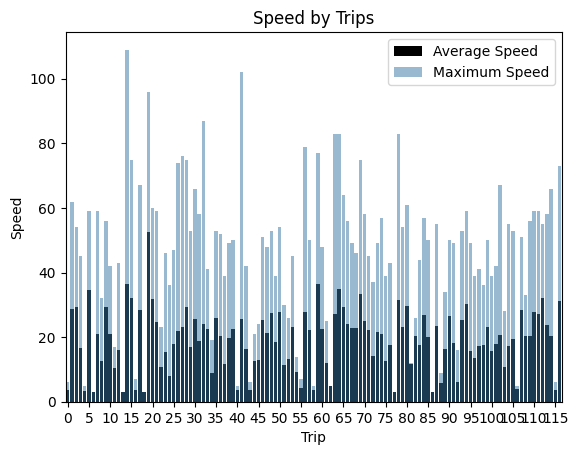

In [6]:
print('Number of Trips:',len(trips_df))
print('Average Speed:',round(trips_df['avg_speed'].mean(),2))
print('Maximum Speed:',trips_df['max_speed'].max())

fig, ax = plt.subplots()
sns.barplot(trips_df, x=trips_df.index, y='avg_speed', ax=ax, label='Average Speed',color='k')
sns.barplot(trips_df, x=trips_df.index, y='max_speed',ax=ax, label='Maximum Speed',alpha=0.5)
ax.set_xticks(ticks=[i for i in range(0,len(trips_df),5)])
ax.set(title='Speed by Trips',xlabel='Trip',ylabel='Speed')
ax.legend()
plt.show()

Fuel Consumption Estimation

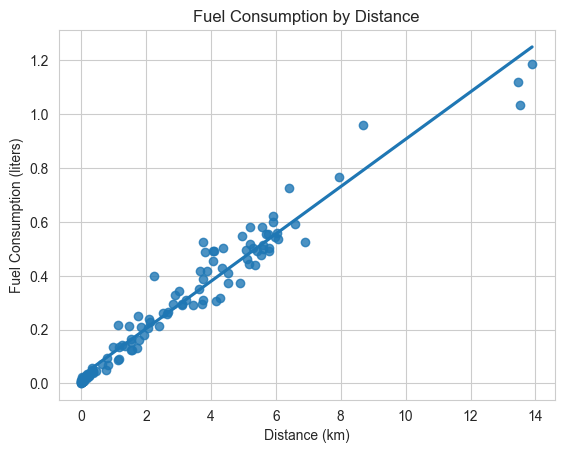

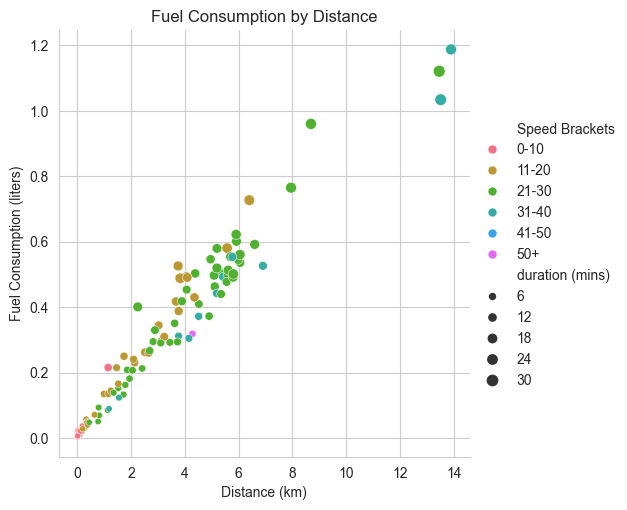

In [7]:
trips_df['fuel_mass_flow_rate'] = trips_df['MAF'] / trips_df['FAR']

trips_df['fuel consumption (kg)'] = trips_df['fuel_mass_flow_rate'] * (trips_df['duration (mins)']*60) #converting to seconds

trips_df['fuel_consumption (liters)'] = trips_df['fuel consumption (kg)'] / 0.75 #density of fuel = 0.75 kg/

speed_labels = ['0-10','11-20','21-30','31-40','41-50','50+']
speed_bins = [0,10,20,30,40,50,np.inf]
trips_df['Speed Brackets'] = pd.cut(trips_df['avg_speed'], bins=speed_bins, labels=speed_labels)


sns.set_style("whitegrid") 
sns.regplot(trips_df, x='dist',y='fuel_consumption (liters)',ci=None).set(title='Fuel Consumption by Distance', \
                        xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
plt.show()
sns.relplot(trips_df, x='dist', y='fuel_consumption (liters)',size='duration (mins)',hue='Speed Brackets',palette='husl') \
                        .set(title='Fuel Consumption by Distance',xlabel='Distance (km)', ylabel='Fuel Consumption (liters)')
plt.show()

Acceleration Analysis

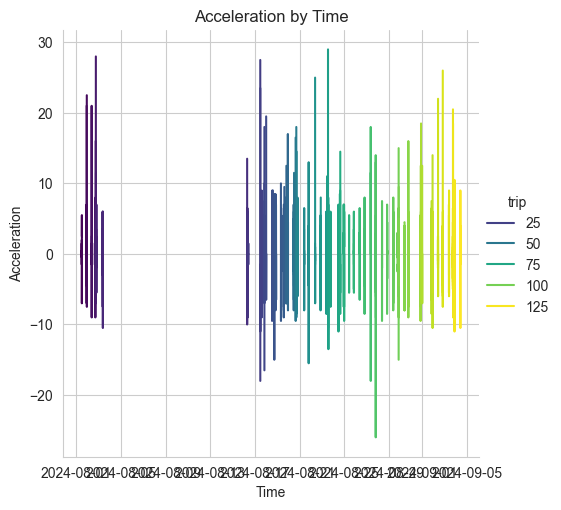

In [8]:
acc_analysis= pd.DataFrame()
for i in range(len(trips)):
    if trips[i]['vehicle_speed'].mean() != 0:
        trips[i]['trip'] = i+1
        acc_analysis = pd.concat([acc_analysis,trips[i]])

acc_analysis['acceleration'] = acc_analysis['acceleration']*3600/1000
sns.relplot(acc_analysis, x='time_stamp',y='acceleration',kind='line',hue='trip',palette='viridis') \
.set(title='Acceleration by Time',xlabel='Time',ylabel='Acceleration')

Looking for Patterns

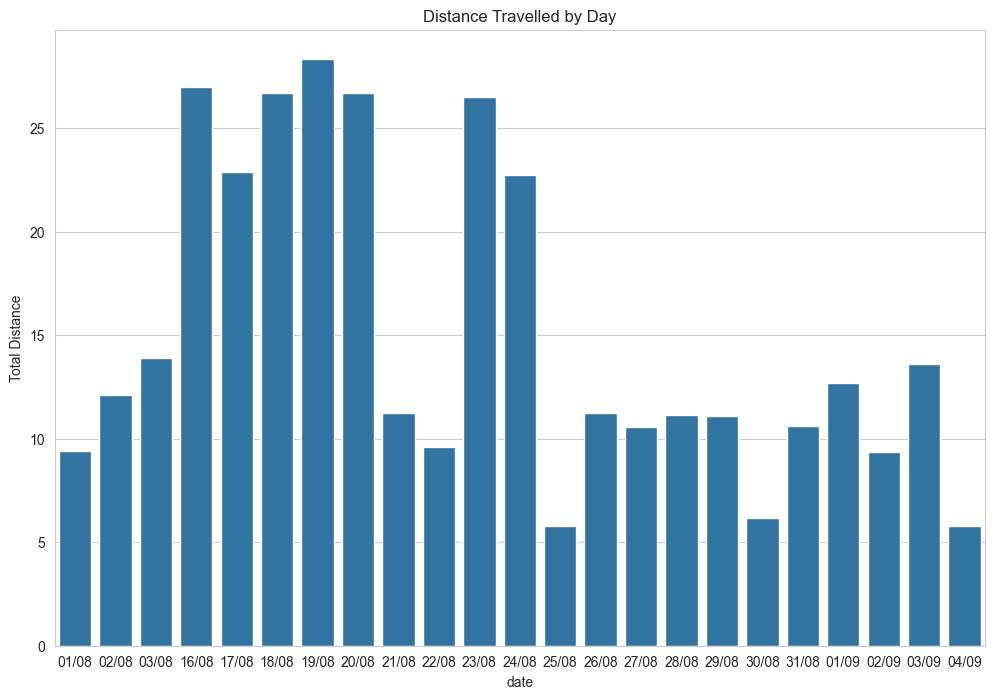

Most Travelled on: 2024-08-19 
Distance: 28.34

Peak Hour
hour           9
trip_count    18
Name: 3, dtype: int64


In [9]:
trips_df['date'] = trips_df['trip_start'].dt.date
total_dist_by_day = trips_df.groupby('date')['dist'].sum().reset_index(name='Total Distance')

total_dist_by_day['date'] = pd.to_datetime(total_dist_by_day['date'])

plt.figure(figsize=(12,8))
sns.barplot(total_dist_by_day, x='date', y='Total Distance').set(title='Distance Travelled by Day')
ticks = total_dist_by_day['date'].dt.strftime('%d/%m')
plt.xticks(ticks=range(len(total_dist_by_day)), labels=ticks)
plt.show()
most_tarvel = total_dist_by_day[total_dist_by_day['Total Distance']==total_dist_by_day['Total Distance'].max()][['date','Total Distance']].values
print('Most Travelled on:',most_tarvel[0][0].date(),'\nDistance:',round(most_tarvel[0][1],2))

trips_df['hour'] = trips_df['trip_start'].dt.hour
peak_times = trips_df.groupby('hour').size().reset_index(name = 'trip_count')
peak_hour = peak_times.loc[peak_times['trip_count'].idxmax()]
print('\nPeak Hour')
print(peak_hour)

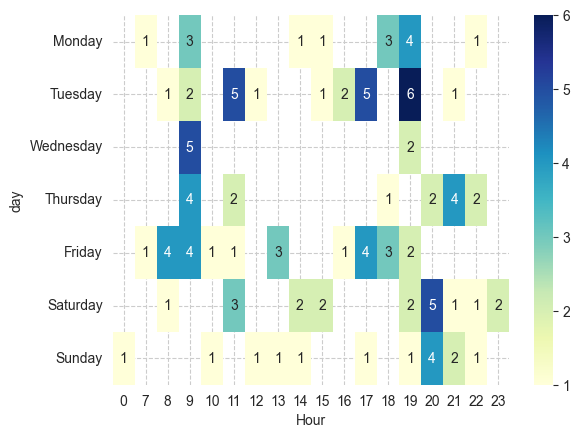

In [10]:
trips_df['day'] = trips_df['trip_start'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_df['day'] = pd.Categorical(trips_df['day'],categories=day_order, ordered=True)

heatmap = trips_df.pivot_table(index='day',columns=trips_df['trip_start'].dt.hour, values='dist', aggfunc='count', observed=True)
# print(heatmap)
sns.heatmap(heatmap, cmap='YlGnBu', annot=True).set(xlabel='Hour')
plt.grid(linestyle='--')
plt.show()

Clustering

C:\Users\DELL\AppData\Local\Temp\ipykernel_16244\2114812399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


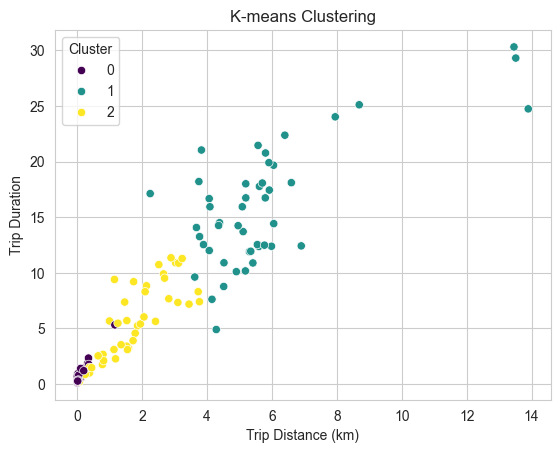

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data)

kmeans = KMeans(n_clusters=3, random_state=42)  # We choose 3 clusters
kmeans.fit(df_scaled)

data['Cluster'] = kmeans.labels_

sns.scatterplot(data=data, x='dist', y='duration (mins)', hue='Cluster', palette='viridis')
plt.title('K-means Clustering')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration')
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_16244\3999008360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = dbscan.labels_


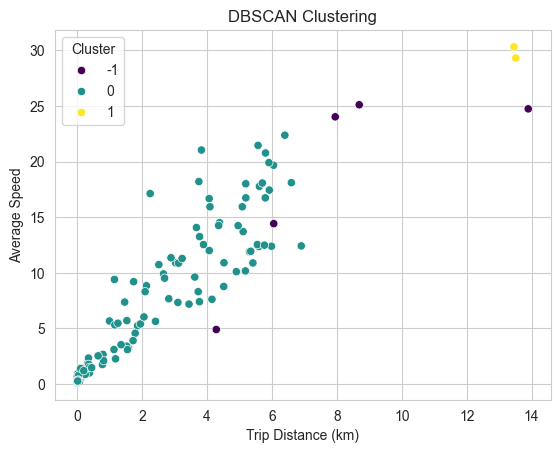

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

df = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

dbscan = DBSCAN(eps=0.8, min_samples=2)
dbscan.fit(df_scaled)

df['Cluster'] = dbscan.labels_

sns.scatterplot(x='dist', y='duration (mins)', hue='Cluster', palette='viridis', data=df)

plt.title('DBSCAN Clustering')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Average Speed')

plt.show()


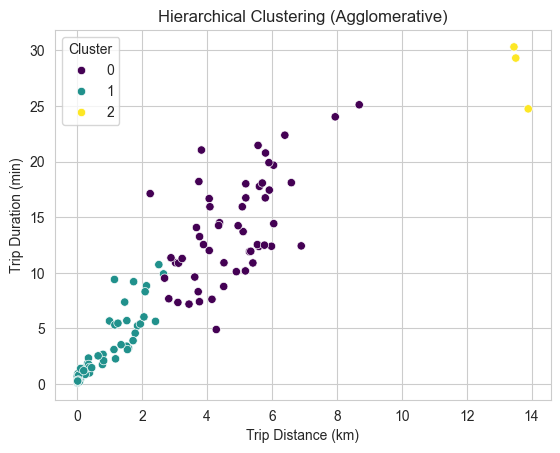

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

HierClust_df = trips_df[['duration (mins)','dist','avg_speed','max_speed','fuel_consumption (liters)']]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(HierClust_df)

hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
trips_df['Cluster'] = hc.fit_predict(df_scaled)

sns.scatterplot(x='dist', y='duration (mins)', hue='Cluster', data=trips_df, palette='viridis')
plt.title('Hierarchical Clustering (Agglomerative)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Trip Duration (min)')
plt.show()


Analysis on the Clusters

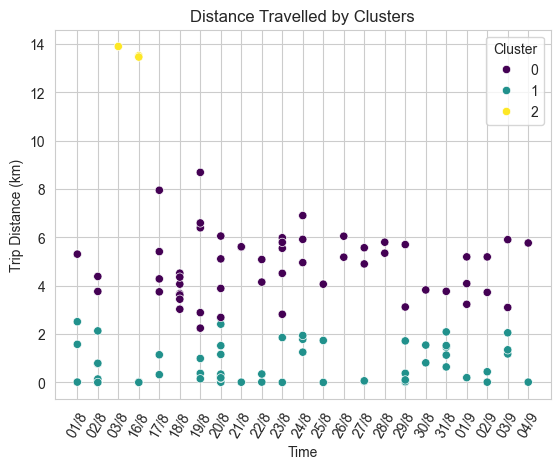

Cluster
0     4.787541
1     0.764015
2    13.621123
Name: dist, dtype: float64
            trip_start            trip_end  duration (mins)  avg_speed  \
14 2024-08-03 08:38:57 2024-08-03 09:03:41        24.733333  36.492690   
15 2024-08-16 07:12:26 2024-08-16 07:41:44        29.300000  32.133598   
17 2024-08-16 08:22:02 2024-08-16 08:52:20        30.300000  28.257611   

    max_speed      dist      MAF        FAR  time b/w trips  \
14      109.0  13.89558  0.00851  14.184541       1116525.0   
15       75.0  13.51163  0.00630  14.289324          2358.0   
17       67.0  13.45616  0.00658  14.234941          2796.0   

    fuel_mass_flow_rate  fuel consumption (kg)  fuel_consumption (liters)  \
14             0.000600               0.890303                   1.187071   
15             0.000441               0.775077                   1.033436   
17             0.000462               0.840340                   1.120453   

   Speed Brackets        date  hour       day  Cluster date/m

In [14]:
trips_df['date'] = trips_df['date'].astype(str)
trips_df['date/month'] = trips_df['date'].str[8:] + '/' + trips_df['date'].str[6:7]

sns.set_style('whitegrid')
sns.scatterplot(data=trips_df, x='date/month' ,y='dist',hue='Cluster',palette='viridis')
plt.title('Distance Travelled by Clusters')
plt.xticks(rotation=60)
plt.xlabel('Time')
plt.ylabel('Trip Distance (km)')
plt.show()
print(trips_df.groupby('Cluster')['dist'].agg('mean'))

print(trips_df.loc[trips_df['Cluster']== 2])

In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Check the actual time column
# If your column isn't called 'time_stamp', replace it below with the correct name
# Assuming it's named 'trip_start' or something similar, replace 'time_stamp'

# Example Load Calculation (simplified version):
def calculate_load(rpm, speed):
    return (rpm * speed) / 1000  # Arbitrary formula for demo purposes

# Ensure 'trip_start' is in datetime format
trips_df['trip_start'] = pd.to_datetime(trips_df['trip_start'])

# Function to plot the graph with interactivity
def plot_parameters_with_interactivity(start_time, end_time):
    # Filter data for the given time range
    mask = (trips_df['trip_start'] >= start_time) & (trips_df['trip_start'] <= end_time)
    filtered_df = trips_df[mask].copy()

    # Add calculated columns if needed
    filtered_df['load'] = calculate_load(filtered_df['rpm'], filtered_df['speed'])
    filtered_df['fuel_efficiency'] = filtered_df['distance'] / (filtered_df['fuel_consumption (liters)'] + 1e-6)  # Prevent division by zero

    # Normalize data for visual comparison
    normalized_df = filtered_df[['fuel_efficiency', 'speed', 'rpm', 'distance', 'load']].copy()
    for col in normalized_df.columns:
        normalized_df[col] = (filtered_df[col] - filtered_df[col].min()) / (filtered_df[col].max() - filtered_df[col].min())

    # Create the interactive plot
    fig = make_subplots(specs=[[{"secondary_y": True}]])  # Allows dual y-axes

    # Add each line for parameters
    for col in normalized_df.columns:
        fig.add_trace(go.Scatter(
            x=filtered_df['trip_start'],  # Ensure time_stamp is replaced by trip_start or actual time column
            y=normalized_df[col],
            mode='lines+markers',
            name=col,
            text=[f"{col}: {val:.2f}" for val in filtered_df[col]],  # Hover text
            hoverinfo='text+x',
            marker=dict(size=6)
        ))

        # Highlight max points for each parameter
        max_idx = filtered_df[col].idxmax()
        fig.add_trace(go.Scatter(
            x=[filtered_df['trip_start'][max_idx]],
            y=[normalized_df[col][max_idx]],
            mode='markers',
            marker=dict(color='red', size=10, symbol='star'),
            name=f"Max {col}"
        ))

    # Update layout
    fig.update_layout(
        title="Vehicle Parameter Analysis Over Time",
        xaxis_title="Time",
        yaxis_title="Normalized Values",
        legend_title="Parameters",
        hovermode="x unified",  # Unified hover across parameters
        template="plotly_white",
    )

    # Show plot
    fig.show()

# Example usage with specific time range
plot_parameters_with_interactivity('2023-10-01 08:00', '2023-10-01 10:00')



KeyError: 'time_stamp'